# Test the performance of MDM vs QDM + Sort for the globe

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
# import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import pandas as pd
import random

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [79]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
#########
locn   = 'chicago'
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
cesm2_path        = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals             = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cmip6_cvals       = cvals + 'cmip6/'
############
pi_year  = 1865
eoc_year = 2086
#
doy  = 211
#############################
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [3]:
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  

In [4]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [5]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(2)

In [6]:
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'
pi_year   = 1865
eoc_year  = 2071
doy       = 211 # day_of_year
#date      = 'Jul30'

In [7]:
cluster

Dashboard: http://10.0.2.2:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.2.2:43051,Workers: 0
Dashboard: http://10.0.2.2:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Compare QDM + Sort and MDM 

### Load CESM2 data

In [8]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 709 ms, sys: 211 ms, total: 919 ms
Wall time: 2.43 s


In [9]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tpi   = ds_hist.TREFHTMX.sel(method='nearest').sel(time=slice(pi_year0,pi_year1))

teoc  = ds_ssp.TREFHTMX.sel(method='nearest').sel(time=slice(ic_year0,ic_year1))

CPU times: user 177 ms, sys: 2.07 ms, total: 179 ms
Wall time: 175 ms


In [10]:
tdpi  = to_daily(tpi)
tdeoc = to_daily(teoc)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

In [11]:
######################

In [59]:
# Total range of numbers
total_range = list(range(1, 100))

# Generate the first list of N unique random numbers
N = 1
random.seed(42) 
model_list = random.sample(total_range, N)

# Remove these numbers from the total range to avoid repetition
remaining_range = [num for num in total_range if num not in model_list]

# Generate the second list of 10 unique random numbers from the remaining numbers
obs_list = random.sample(remaining_range, N)

model_list = model_list + [99,0]
obs_list   = obs_list + [0,1]

# Pair the numbers together
paired_numbers = list(zip(model_list, obs_list))
#

# Print the pairs
print("List of pairs:")
for pair in paired_numbers:
    print(pair)

List of pairs:
(82, 15)
(99, 0)
(0, 1)


### Select Observation and Model indices. Detrend data.

In [96]:
############ Select some ensemble as obs and another as model ######
#
pi_obs  = tdpi.sel(member = obs_list)
eoc_obs = tdeoc.sel(member= obs_list)
#
#
pi_model_det  = xr.open_zarr(cvals+'pi_detrended.zarr').detrended_tmax
eoc_model_det = xr.open_zarr(cvals+'eoc_detrended.zarr').detrended_tmax
#
pi_model_det  = pi_model_det.sel(member = model_list)
eoc_model_det = eoc_model_det.sel(member = model_list)
#
pi_model  = tdpi.sel(member = model_list)
eoc_model = tdeoc.sel(member = model_list)
#
pi_model  = pi_model.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
eoc_model = eoc_model.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
pi_obs    = pi_obs.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
eoc_obs   = eoc_obs.chunk({'lat':8,'lon':60,'member':-1,'year':10,'dayofyear':73})
eoc_obs

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, member: 3, year: 30,
                              dayofyear: 365)>
dask.array<rechunk-merge, shape=(192, 288, 3, 30, 365), dtype=float32, chunksize=(8, 60, 3, 10, 73), chunktype=numpy.ndarray>
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member     (member) int64 15 0 1
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [97]:
pi_model  = pi_model.rename({'member':'model_id'})
eoc_model = eoc_model.rename({'member':'model_id'})
#
pi_model_det  = pi_model_det.rename({'member':'model_id'})
eoc_model_det = eoc_model_det.rename({'member':'model_id'})
#
pi_obs     = pi_obs.rename({'member':'obs_id'})
eoc_obs    = eoc_obs.rename({'member':'obs_id'})

In [62]:
pi_omean  = pi_obs.mean('year')
#
pi_mmean  = pi_model_det.mean('year')
pi_mstd   = pi_model_det.std('year')
#
eoc_mmean = eoc_model_det.mean('year')
eoc_mstd  = eoc_model_det.std('year')
pi_mmean

<xarray.DataArray 'detrended_tmax' (lat: 192, lon: 288, model_id: 3,
                                    dayofyear: 365)>
dask.array<mean_agg-aggregate, shape=(192, 288, 3, 365), dtype=float64, chunksize=(8, 60, 3, 73), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 220 221 222 223 224 225 ... 142 143 144 145 146
    degree     int64 ...
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * model_id   (model_id) int64 82 99 0

## Perform Moment Delta Mapping

In [65]:
pi_mdm  = implement_mdm(pi_obs,pi_mmean,eoc_mmean,pi_mstd,eoc_mstd)

In [66]:
qpi_mdm = compute_quantiles(pi_mdm)
qpi_mdm = qpi_mdm.chunk({'obs_id':-1})
qpi_mdm

<xarray.DataArray (quantile: 30, lat: 192, lon: 288, obs_id: 3, dayofyear: 365,
                   model_id: 3)>
dask.array<transpose, shape=(30, 192, 288, 3, 365, 3), dtype=float64, chunksize=(30, 8, 60, 3, 73, 3), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 15 0 1
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * model_id   (model_id) int64 82 99 0
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [67]:
%%time
# qpi_mdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_mdm_216examples.zarr',mode='w')
# qpi_mdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_mdm_27examples.zarr',mode='w')

CPU times: user 3min 23s, sys: 10.4 s, total: 3min 33s
Wall time: 5min 7s


## Perform Quantile Delta Mapping

In [98]:
qpi_model  = compute_quantiles(pi_model)
qeoc_model = compute_quantiles(eoc_model)
#
qpi_obs  = compute_quantiles(pi_obs)
qeoc_obs = compute_quantiles(eoc_obs)
#
qano     = qeoc_model - qpi_model

In [69]:
qpi_qdm =  qpi_obs + qano
qpi_qdm = qpi_qdm.chunk({'obs_id':-1})
qpi_qdm

<xarray.DataArray 'TREFHTMX' (quantile: 30, lat: 192, lon: 288, obs_id: 3,
                              dayofyear: 365, model_id: 3)>
dask.array<add, shape=(30, 192, 288, 3, 365, 3), dtype=float64, chunksize=(30, 8, 60, 3, 73, 3), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 15 0 1
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) int64 82 99 0

In [70]:
%%time
# qpi_qdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_qdm_216examples.zarr',mode='w')
# qpi_qdm.rename('tmax').to_dataset().to_zarr(cvals+'qpi_qdm_27examples.zarr',mode='w')

CPU times: user 2min 18s, sys: 6.19 s, total: 2min 24s
Wall time: 3min 35s


## MDM vs QDM

In [71]:
qpi_mdm = xr.open_zarr(cvals+'qpi_mdm_27examples.zarr').tmax
qpi_qdm = xr.open_zarr(cvals+'qpi_qdm_27examples.zarr').tmax
# qpi_mdm = xr.open_zarr(cvals+'qpi_mdm_216examples.zarr').tmax
# qpi_qdm = xr.open_zarr(cvals+'qpi_qdm_216examples.zarr').tmax
qpi_mdm

<xarray.DataArray 'tmax' (quantile: 30, lat: 192, lon: 288, obs_id: 3,
                          dayofyear: 365, model_id: 3)>
dask.array<open_dataset-06780d74cd8219502f1fdf93b472848btmax, shape=(30, 192, 288, 3, 365, 3), dtype=float64, chunksize=(30, 8, 60, 3, 73, 3), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * model_id   (model_id) int64 82 99 0
  * obs_id     (obs_id) int64 15 0 1
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

## Select model and observations and plot

In [72]:
model_index = 0
obs_index   = 0

In [73]:
%%time
doy  = 300
date = no_leap_date(doy)
#
qpi_mdm_day    = qpi_mdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                  .sel(model_id = model_index).sel(obs_id = obs_index)
#
qpi_qdm_day    = qpi_qdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                    .sel(model_id = model_index).sel(obs_id = obs_index)

CPU times: user 11.6 ms, sys: 22 µs, total: 11.6 ms
Wall time: 11.2 ms


In [74]:
qpi_sqdm  = xr.apply_ufunc(
    np.sort,
    qpi_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
qpi_sqdm

<xarray.DataArray 'tmax' (lat: 192, lon: 288, obs_id: 3, dayofyear: 365,
                          model_id: 3, quantile: 30)>
dask.array<transpose, shape=(192, 288, 3, 365, 3, 30), dtype=float64, chunksize=(8, 60, 3, 73, 3, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * model_id   (model_id) int64 82 99 0
  * obs_id     (obs_id) int64 15 0 1
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [75]:
qpi_sqdm_day = qpi_sqdm.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest')\
                .sel(model_id = model_index).sel(obs_id = obs_index)

In [102]:
qeoc_model_day = qeoc_model.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(model_id =model_index)
#
qpi_model_day  = qpi_model.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(model_id =model_index)
#
qpi_obs_day    = qpi_obs.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(obs_id =obs_index)
#
qeoc_obs_day   = qeoc_obs.sel(dayofyear=doy).sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(obs_id =obs_index)

CPU times: user 1min 48s, sys: 5.41 s, total: 1min 54s
Wall time: 5min 34s


Text(0.05, 0.95, 'obs_index = 0\nmodel_index = 0')

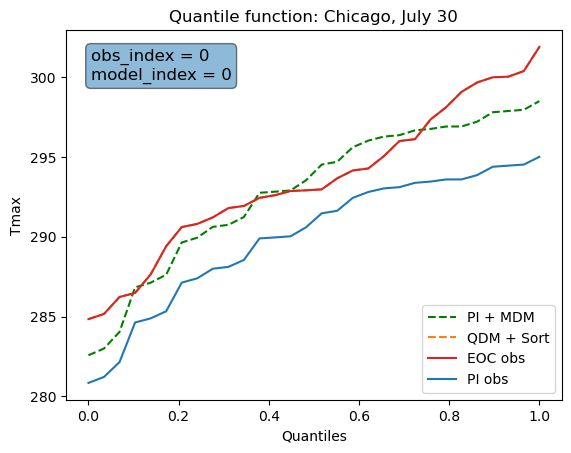

In [80]:
%%time
text_str = f'obs_index = {obs_index}\nmodel_index = {model_index}'  # Construct the text string with line breaks
#
plt.plot(quants,qpi_mdm_day,'--',color='green',label='PI + MDM')
plt.plot(quants,qpi_sqdm_day,'--',color='tab:orange',label='QDM + Sort')
plt.plot(quants,qeoc_obs_day,color='tab:red',label ='EOC obs')
plt.plot(quants,qpi_obs_day,color= 'tab:blue', label ='PI obs')
#
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('Quantile function: Chicago, ' + date)
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

### Plot RMSEs of Sorted + QDM and PI + MDM for globe

In [99]:
qeoc_obs = qeoc_obs.expand_dims(dim={'model_id':model_list}).assign_coords(model_id = qpi_mdm.coords['model_id'])
qeoc_obs

<xarray.DataArray 'TREFHTMX' (model_id: 3, quantile: 30, lat: 192, lon: 288,
                              obs_id: 3, dayofyear: 365)>
dask.array<broadcast_to, shape=(3, 30, 192, 288, 3, 365), dtype=float64, chunksize=(3, 30, 8, 60, 3, 73), chunktype=numpy.ndarray>
Coordinates:
  * model_id   (model_id) int64 82 99 0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 15 0 1
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [100]:
rmse_mdm = xs.rmse(qeoc_obs,qpi_mdm,dim='quantile')
rmse_mdm

<xarray.DataArray (model_id: 3, lat: 192, lon: 288, obs_id: 3, dayofyear: 365)>
dask.array<transpose, shape=(3, 192, 288, 3, 365), dtype=float64, chunksize=(3, 8, 60, 3, 73), chunktype=numpy.ndarray>
Coordinates:
  * model_id   (model_id) int64 82 99 0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 15 0 1

In [104]:
rmse_sqdm = xs.rmse(qeoc_obs,qpi_sqdm,dim='quantile')
rmse_sqdm

<xarray.DataArray (model_id: 3, lat: 192, lon: 288, obs_id: 3, dayofyear: 365)>
dask.array<transpose, shape=(3, 192, 288, 3, 365), dtype=float64, chunksize=(3, 8, 60, 3, 73), chunktype=numpy.ndarray>
Coordinates:
  * model_id   (model_id) int64 82 99 0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * obs_id     (obs_id) int64 15 0 1

In [101]:
# %%time
# rmse_mdm.rename('tmax').to_dataset().to_zarr(cvals+'rmse_mdm_27examples.zarr',mode='w')

CPU times: user 1min 38s, sys: 4.85 s, total: 1min 43s
Wall time: 3min 25s


In [105]:
# %%time
# rmse_sqdm.rename('tmax').to_dataset().to_zarr(cvals+'rmse_sqdm_27examples.zarr',mode='w')

CPU times: user 1min 45s, sys: 5.38 s, total: 1min 50s
Wall time: 4min 23s


In [106]:
%%time
rmse_mdm  = xr.open_zarr(cvals+'rmse_mdm_27examples.zarr').tmax
rmse_sqdm = xr.open_zarr(cvals+'rmse_sqdm_27examples.zarr').tmax

CPU times: user 88.4 ms, sys: 18.4 ms, total: 107 ms
Wall time: 127 ms


In [107]:
rmse_mdm_day  = rmse_mdm.sel(model_id=model_index).sel(obs_id=obs_index).sel(dayofyear=doy)
rmse_sqdm_day = rmse_sqdm.sel(model_id=model_index).sel(obs_id=obs_index).sel(dayofyear=doy)

CPU times: user 762 ms, sys: 53.5 ms, total: 816 ms
Wall time: 807 ms


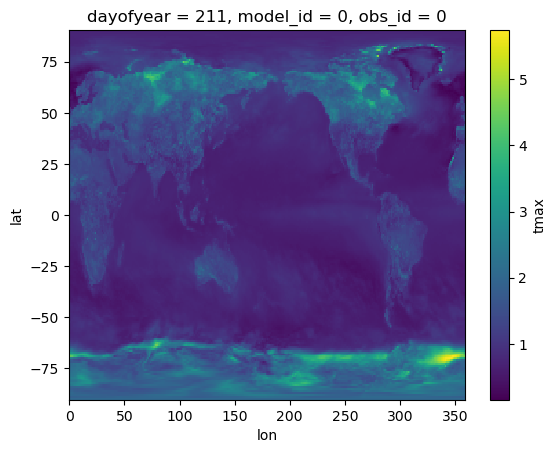

In [108]:
%%time
rmse_mdm_day.plot()

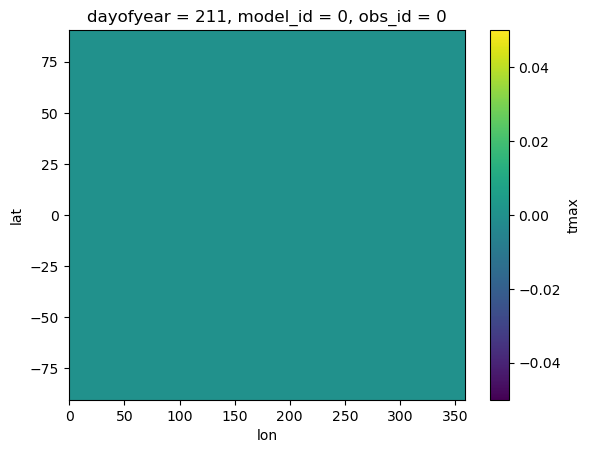

In [109]:
rmse_sqdm_day.plot()

In [29]:
is_sorted(qpi_sqdm_day.values)

False

In [30]:
is_sorted(qpi_mdm_day.values)

True

In [31]:
%%time
xs.rmse(qeoc_obs_day,qpi_mdm_day).values


KeyboardInterrupt



In [32]:
%%time
xs.rmse(qeoc_obs_day,qpi_qdm_day).values


KeyboardInterrupt



### Delete below this later 

In [ ]:
####### #########Test for sorting. Don't delete. ######

In [ ]:
# # Seed for reproducibility
# np.random.seed(42)

# # Dimensions
# quantiles = np.array([0.1, 0.5, 0.9, 0.3, 0.7])
# lats = np.array([10, 20])
# lons = np.array([100, 110])

# # Generating random data
# forecast_data = np.random.rand(5, 2, 2)  # Random forecast data
# true_data = np.random.rand(5, 2, 2)  # Random true values

# # Creating DataArrays
# forecast_arr = xr.DataArray(forecast_data, dims=['quantile', 'lat', 'lon'],
#                             coords={'quantile': quantiles, 'lat': lats, 'lon': lons})

# true_value_arr = xr.DataArray(true_data, dims=['quantile', 'lat', 'lon'],
#                               coords={'quantile': quantiles, 'lat': lats, 'lon': lons})

In [ ]:
# forecast_arr.sel(lat=10,lon=100).values

In [ ]:
# sorted_forecast_arr = xr.apply_ufunc(
#     np.sort,
#     forecast_arr,
#     input_core_dims=[['quantile']],
#     output_core_dims=[['quantile']],
#     dask='parallelized'
# )

In [ ]:
# sorted_forecast_arr 

In [ ]:
# sorted_forecast_arr.sel(lat=10,lon=100).values